In [0]:
!pip install shap
!pip install importlib
!pip install lifelines
!pip install plotly

In [0]:
from google.colab import auth
from google.colab import drive
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)
auth.authenticate_user()
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls '/content/gdrive/My Drive/MD.KimSW'

In [0]:
home_path = '/content/gdrive/My Drive/'
df = pd.read_csv(home_path + 'MD.KimSW/2019.08.29 면역정보-표 1.csv')

In [0]:
cols1 = list(df.columns)
cols2 = df.iloc[0].values
cols = df.iloc[1].values
for i, c in enumerate(cols2):
  if type(cols[i]) != str:
    cols[i] = ''
  if type(c) == str:
    prefix2 = c
    if type(cols1[i]) == str and not cols1[i].startswith('Unnamed'):
      prefix1 = cols1[i]
  if type(cols[i]) == str and ('epithelial' in cols[i] or 'stromal' in cols[i]):
    cols[i] = '_'.join([prefix1, prefix2, cols[i]])
cols

array(['', '등록번호', '성별', '나이', '이름', '병리 검사번호', 'excluded',
       'CD3_invasion front_epithelial1', 'CD3_invasion front_epithelial2',
       'CD3_invasion front_stromal1', 'CD3_invasion front_stromal2',
       'CD3_center_epithelial1', 'CD3_center_epithelial2',
       'CD3_center_stromal1', 'CD3_center_stromal2',
       'CD8_invasion front_epithelial1', 'CD8_invasion front_epithelial2',
       'CD8_invasion front_stromal1', 'CD8_invasion front_stromal2',
       'CD8_center_epithelial1', 'CD8_center_epithelial2',
       'CD8_center_stromal1', 'CD8_center_stromal2',
       'Foxp3_invasion front_epithelial1',
       'Foxp3_invasion front_epithelial2',
       'Foxp3_invasion front_stromal1', 'Foxp3_invasion front_stromal2',
       'Foxp3_center_epithelial1', 'Foxp3_center_epithelial2',
       'Foxp3_center_stromal1', 'Foxp3_center_stromal2',
       'CD68_invasion front_epithelial1',
       'CD68_invasion front_epithelial2', 'CD68_invasion front_stromal1',
       'CD68_invasion front_strom

In [0]:
df.columns = cols
df = df.drop([0, 1]).reset_index(drop=True)[:24]

In [0]:
df.shape

(24, 98)

In [0]:
X_cols = ['excluded'] + list(filter(lambda x: ('epithelial' in x) or ('stromal' in x), cols))

In [0]:
i = 0
df_arr = list()
df_cols = list()
while i < len(X_cols):
  if X_cols[i].endswith('1'):
    df_cols.append(X_cols[i][:-1])
    df_arr.append(df[[X_cols[i], X_cols[i+1]]].mean(1).values)
    i += 2
  else:
    df_cols.append(X_cols[i])
    df_arr.append(df[X_cols[i]])
    i += 1
df_arr = pd.DataFrame(np.array(df_arr).T, columns=df_cols)

In [0]:
df_arr.head()

,excluded,CD3_invasion front_epithelial,CD3_invasion front_stromal,CD3_center_epithelial,CD3_center_stromal,CD8_invasion front_epithelial,CD8_invasion front_stromal,CD8_center_epithelial,CD8_center_stromal,Foxp3_invasion front_epithelial,Foxp3_invasion front_stromal,Foxp3_center_epithelial,Foxp3_center_stromal,CD68_invasion front_epithelial,CD68_invasion front_stromal,CD68_center_epithelial,CD68_center_stromal,CD163_invasion front_epithelial,CD163_invasion front_stromal,CD163_center_epithelial,CD163_center_stromal
0,0,2506.5,82.5,15,60.5,121,116,56.5,0,36.5,0,0.5,0,1510,26,1465,12.5,1913.5,26,2282.5,27.5
1,1,626,1565,1206,5,8.5,110,93,0.5,5.5,0,6,0,456.5,614,69.5,10.5,41.5,906,42.5,757.5
2,0,36560.5,155,85110,12.5,27,6,1260,7.5,58.5,5,405,0,3520,505,3084,7.5,2116,26,2632.5,27.5
3,0,61572.5,256,7047.5,28,1555,110,1765.5,0.5,5.5,0,36,5,505,11,1878.5,12.5,355,2773,47551,26
4,0,105,2030.5,84,12.5,0,0,5.5,0,0,0,0,0,757.5,4778,1610.5,517.5,54,2821,2110,505


In [0]:
from importlib.machinery import SourceFileLoader

preprocessing = SourceFileLoader('preprocessing', home_path + 'modeling_tools/preprocessing.py').load_module()
tree_modeling = SourceFileLoader('tree_modeling', home_path + 'modeling_tools/tree_modeling.py').load_module()
survival_analysis = SourceFileLoader('tree_modeling', home_path + 'modeling_tools/survival_analysis.py').load_module()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
y = df['recur'].values[:, 0]
y[y == '1/n'] = '1'
y = list(map(lambda x: int(x), y))
y

[0, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]

In [0]:
y_01 = list(map(lambda x: 0 if x == 2 else x, y))
y_01

[0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]

In [0]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
df_nor = sc.fit_transform(df_arr)
df_nor = pd.DataFrame(df_nor, columns=df_arr.columns)

In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(class_weight='balanced', max_iter=10).fit(df_nor, y_01)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
pred1 = clf.predict(df_nor)
score1 = clf.predict_proba(df_nor)[:, 1]
tree_modeling.compute_performance(y_01, pred1, score1)

{'AUC': 0.9214285714285715, 'accuracy': 0.9166666666666666, 'precision': 0.8333333333333334, 'recall': 1.0, 'f1': 0.9090909090909091, 'mcc': 0.8451542547285166}


{'AUC': 0.9214285714285715,
 'accuracy': 0.9166666666666666,
 'f1': 0.9090909090909091,
 'mcc': 0.8451542547285166,
 'precision': 0.8333333333333334,
 'recall': 1.0}

In [0]:
pd.DataFrame({'feature': [''] + list(df_nor.columns),  'coefficient': list(clf.intercept_) + list(clf.coef_[0])})

,feature,coefficient
0,,0.535148
1,excluded,-0.195034
2,CD3_invasion front_epithelial,0.059012
3,CD3_invasion front_stromal,-0.799242
4,CD3_center_epithelial,-0.874391
5,CD3_center_stromal,-0.408303
6,CD8_invasion front_epithelial,-0.131720
7,CD8_invasion front_stromal,0.208496
8,CD8_center_epithelial,-0.261276
9,CD8_center_stromal,0.273277


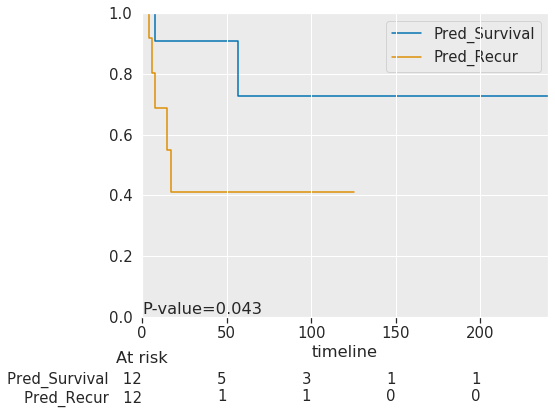

<lifelines.KaplanMeierFitter: fitted with 12 total observations, 7 right-censored observations>

In [0]:
event = np.array(list(map(lambda x: int(x), df['death'].values[:, 0])))
dur= df['duration (month)'].astype('int')
survival_analysis.do_KM_analysis(dur, pred1, event, ['Pred_Survival', 'Pred_Recur'])

In [0]:
from scipy.stats import spearmanr
yy = sc.fit_transform(np.array([y_01, event, dur]).T)
cors, ps = spearmanr(df_nor.values, yy)

In [0]:
cors.shape

(24, 24)

In [0]:
cors_X_yy = cors[df_nor.shape[1]:, :]
cors_X_yy.shape

(3, 24)

In [0]:
yy_cols = ['recur', 'death', 'duration(month)']
cors_X_yy = pd.DataFrame(cors_X_yy, index=yy_cols, columns=list(df_nor.columns)+yy_cols)

In [0]:
cors_X_yy

,excluded,CD3_invasion front_epithelial,CD3_invasion front_stromal,CD3_center_epithelial,CD3_center_stromal,CD8_invasion front_epithelial,CD8_invasion front_stromal,CD8_center_epithelial,CD8_center_stromal,Foxp3_invasion front_epithelial,Foxp3_invasion front_stromal,Foxp3_center_epithelial,Foxp3_center_stromal,CD68_invasion front_epithelial,CD68_invasion front_stromal,CD68_center_epithelial,CD68_center_stromal,CD163_invasion front_epithelial,CD163_invasion front_stromal,CD163_center_epithelial,CD163_center_stromal,recur,death,duration(month)
recur,-0.170445,-0.024419,-0.183140,0.024419,-0.055219,-0.103802,0.109932,-0.048848,0.061327,-0.233044,-0.147476,-0.110148,0.000000,-0.525002,-0.201850,-0.183140,-0.514024,-0.146512,-0.006135,-0.085465,-0.342603,1.000000,0.201435,-0.372628
death,-0.008403,-0.019864,-0.086079,-0.324451,-0.179680,-0.251670,0.019873,-0.132458,-0.625278,-0.352550,-0.106640,-0.391603,-0.142190,-0.218508,0.291916,0.139050,-0.106197,-0.350937,0.346050,-0.099322,-0.108103,0.201435,1.000000,-0.318037
duration(month),0.576442,0.234501,0.399391,0.160975,-0.045038,0.214099,-0.064418,-0.071584,-0.140517,0.306165,0.378870,0.423463,0.012457,0.182293,0.271142,-0.025234,0.099651,0.192299,0.226718,0.060474,-0.159152,-0.372628,-0.318037,1.000000


In [0]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(z=cors_X_yy.values, y=cors_X_yy.index, x=cors_X_yy.columns, type = 'heatmap', colorscale = 'Viridis'))
fig.show()

In [0]:
score1

array([0.60630242, 0.51811516, 0.41386908, 0.59174577, 0.30979358,
       0.45441168, 0.35205599, 0.63144692, 0.29169197, 0.56081494,
       0.59690658, 0.314935  , 0.1740292 , 0.38171633, 0.66874463,
       0.22925122, 0.22671648, 0.41080234, 0.61181815, 0.58221734,
       0.68113285, 0.59442908, 0.58281691, 0.17959435])

In [0]:
df.head()

,,등록번호,성별,나이,이름,병리 검사번호,excluded,CD3_invasion front_epithelial1,CD3_invasion front_epithelial2,CD3_invasion front_stromal1,CD3_invasion front_stromal2,CD3_center_epithelial1,CD3_center_epithelial2,CD3_center_stromal1,CD3_center_stromal2,CD8_invasion front_epithelial1,CD8_invasion front_epithelial2,CD8_invasion front_stromal1,CD8_invasion front_stromal2,CD8_center_epithelial1,CD8_center_epithelial2,CD8_center_stromal1,CD8_center_stromal2,Foxp3_invasion front_epithelial1,Foxp3_invasion front_epithelial2,Foxp3_invasion front_stromal1,Foxp3_invasion front_stromal2,Foxp3_center_epithelial1,Foxp3_center_epithelial2,Foxp3_center_stromal1,Foxp3_center_stromal2,CD68_invasion front_epithelial1,CD68_invasion front_epithelial2,CD68_invasion front_stromal1,CD68_invasion front_stromal2,CD68_center_epithelial1,CD68_center_epithelial2,CD68_center_stromal1,CD68_center_stromal2,CD163_invasion front_epithelial1,...,depth,LVI,PNI,radial RM,pT,pN,pM,LN meta,LN size(mm),LN_patho,HMB-45,S-100,melan A,,Good MR image\n(논문에 실릴 만한 case들),gross color,Morphology,Good MR image\n(논문에 실릴 만한 case들),rec_site,Meta,recur,event,treatment,response,diagnosis date,event date,death date,other disease,death,duration,Epicenter,external sphincter,N갯수,Confirm 방법,location,Meta,event,treatment,treatment,diagnosis date
0,1.0,23602144,F,57,배두순,00S 002778,0,50,13,16,5,3,0,12,1,24,2,2,32,11,3,0,0,7,3,0,0,0,1,0,0,30,20,5,2,29,30,2,5,38,...,vaginal wall,1,2,0,NaN,NaN,1,4,NaN,"perirectal 4/9, \nRight obturator 0/2\nLeft obturator 0/2\nright LN? 0/3",NaN,NaN,NaN,NaN,x,grayish brown,"polypoid, multifocal hemorrhagic",x,NaN,진단당시 liver meta,해당없음,1,DD,NaN,NaN,NaN,9/5/00,NaN,1,8,NaN,NaN,16,APR,rectum & anus,initial liver/lung meta,NaN,DD (CTx),DD,1/25/00
1,2.0,25124013,F,60,김도희,01S 003494,1,12,52,3,130,24,12,1,0,1,7,22,0,18,6,0,1,1,1,0,0,1,2,0,0,9,13,12,28,13,9,2,1,8,...,sphincter muscle,0,2,0,NaN,NaN,0,1,NaN,perirectal,NaN,NaN,NaN,NaN,x,tan,polypoid,x,local(presacral),0,1,1,DBCT #6 (initial)\nRec 후 RTx,PD,1/29/01,12/7/01,6/4/02,NaN,1,10,NaN,1,8,APR,anorectal junction,local rec,1,DBCT #6 (initial)\nRec 후 RTx,DBCT #6 (initial)\nRec 후 RTx,1/29/01
2,3.0,26333151,M,38,이웅재,01S 043672,0,73,121,3,10,170,220,2,5,5,4,1,2,25,20,1,5,11,7,1,0,8,10,0,0,70,40,10,10,61,68,1,5,42,...,submucosa,0,2,0,NaN,NaN,0,3,20\nENE 3,perirectal,NaN,NaN,NaN,NaN,x,brownish black,fungating,x,NaN,0,0,0,0,NaN,11/16/01,NaN,NaN,NaN,0,NaN,NaN,0,17,APR,rectum,NaN,0,0,0,11/16/01
3,4.0,26404426,F,66,성갑년,01S 045555,0,123,145,5,12,140,95,5,6,31,10,2,20,35,31,0,1,1,1,0,0,7,2,1,0,10,10,2,2,37,57,2,5,7,...,perirectal soft tissue,0,2,0,NaN,NaN,0,4,NaN,perirectal 4/15\nexternal iliac 0/3,3,3,NaN,NaN,x,NaN,ulcerofungating,x,local(vagina),진단당시 inguinal LN meta,1,1,DBCT#6,PD,11/29/01,5/27/02,9/16/03,NaN,1,NaN,NaN,1,18,APR,rectum and anus (x2),initial inguinal LN meta,1,DBCT#6,DBCT#6,11/29/01
4,5.0,22097011,F,66,이금숙,02S 027936,0,2,10,40,61,16,8,2,5,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,15,15,95,56,32,21,10,35,10,...,perirectal soft tissue,0,2,0,NaN,NaN,0,11,12,perirectal,1,2,NaN,NaN,NaN,NaN,ulceroinfiltrative,x,NaN,NaN,NaN,NaN,NaN,NaN,5/18/02,NaN,2/11/03,NaN,1,NaN,NaN,0,23,APR,anorectum,NaN,9,no,no,5/18/02


In [0]:
recur_yn = np.array(['Survival']*len(y))
recur_yn[np.array(y) == 1] = 'Recur'
recur_yn[np.array(y) == 2] = 'Unknown'
recur_yn

array(['Survival', 'Recur', 'Survival', 'Recur', 'Unknown', 'Survival',
       'Survival', 'Recur', 'Survival', 'Recur', 'Recur', 'Survival',
       'Survival', 'Unknown', 'Recur', 'Survival', 'Survival', 'Survival',
       'Recur', 'Recur', 'Recur', 'Survival', 'Recur', 'Survival'],
      dtype='<U8')

In [0]:
result_df = pd.DataFrame({'label': recur_yn, 'score_of_recur': score1, 'duration(month)': dur})

In [0]:
import plotly.express as px

fig = px.scatter(result_df, x="duration(month)", y="score_of_recur", color="label")
fig.show()